# Parte 1: Extracción y Preprocesamiento del microcurriculo

In [1]:
import pdfplumber
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# ----------------------------------------------
# Ruta del archivo PDF (ajusta si es necesario)
pdf_path = r'D:\Scraping\Asesoria Alejo Formato oficial de curso.pdf'

# Palabras clave para identificar las secciones
secciones_clave = ['2.', '3.', '4.', '5.']
fin_seccion_5 = '6.'
contenido_secciones = []
capturando = False

# Abrir el archivo PDF y extraer el contenido
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        texto = page.extract_text()
        
        # Dividir el texto en líneas
        lineas = texto.split('\n')
        
        # Procesar cada línea
        for linea in lineas:
            # Buscar el inicio de las secciones 2, 3, 4 y 5
            if any(linea.startswith(seccion) for seccion in secciones_clave):
                capturando = True
                contenido_secciones.append(f"--- {linea} ---")
            
            # Capturar el contenido de las secciones
            if capturando:
                contenido_secciones.append(linea)
            
            # Detener la captura al inicio de la sección 6
            if fin_seccion_5 in linea:
                capturando = False
                break

# Unir el contenido capturado en una variable
contenido_final = "\n".join(contenido_secciones)

# Frases literales a eliminar utilizando expresiones regulares
frases_a_eliminar_regex = [
    r"Describir\s+el\s+propósito\s+del\s+curso\s+en\s+relación\s+con\s+los\s+perfiles\s+del\s+programa\s+académico\..*?formación\.",
    r"Explicitar\s+los\s+elementos\s+orientadores\s+del\s+curso\s+de\s+acuerdo\s+con\s+el\s+diseño\s+curricular\s+del\s+programa\s+académico:.*?Programa\.",
    r"Describir\s+cómo\s+el\s+curso\s+hace\s+aportes\s+a\s+la\s+formación\s+integral.*?saberes\.",
    r"Explicitar\s+los\s+ejes\s+problémicos,\s+saberes,.*?programa\s+académico\."
]

# Eliminar las frases no deseadas utilizando las expresiones regulares
for frase_regex in frases_a_eliminar_regex:
    contenido_final = re.sub(frase_regex, '', contenido_final, flags=re.DOTALL)

# Lista de stopwords adicionales en español, incluyendo artículos definidos e indefinidos
stopwords_es = set(stopwords).union({'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'al', 'del'})

# Lista ampliada de stopwords en español
stopwords_es = set(stopwords).union({
    'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 
    'al', 'del', 'y', 'en', 'para', 'con', 'a', 'de', 'por', 
    'se', 'su', 'sus', 'que', 'qué', 'como', 'cómo', 'cuando', 
    'cuándo', 'donde', 'dónde', 'este', 'esta', 'estos', 'estas', 
    'eso', 'esa', 'esos', 'esas', 'mi', 'mis', 'tu', 'tus', 
    'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 
    'vuestra', 'vuestros', 'vuestras', 'yo', 'tú', 'él', 'ella', 
    'nosotros', 'vosotros', 'ellos', 'ellas', 'me', 'te', 'lo', 
    'le', 'les', 'nos', 'os'
})

# Preprocesar el contenido restante
def preprocesar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)  # Eliminar caracteres no deseados
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stopwords_es]  # Filtrar stopwords
    texto_procesado = ' '.join(palabras)
    return texto_procesado

contenido_procesado = preprocesar_texto(contenido_final)
contenido_procesado

'relaciones perfil relaciones perfil pretende formar estudiante capacidades administrativas tecnológicas gestión información través procesos automatizados sistemas información intencionalidades formativas intencionalidades formativas curso pretende desarrollar habilidades bibliotecólogo formación implementación gestión sistemas información faciliten automatización procesos servicios principalmente unidades información lograr objetivo estudiante desarrollará habilidades permitan identificar ajustes mejoras procesos actuales organización así promover implementación nuevos sistemas información faciliten prestación servicios procesos organizaciones igual forma estudiante fortalecerá capacidad identificar sistemas información diseñar nuevas arquitecturas pueda implementar organizaciones información curso también pretende formar estudiante capacidades negociación gestión proveedores sistemas información aportes curso formación integral formación investigación aportes curso formación integral

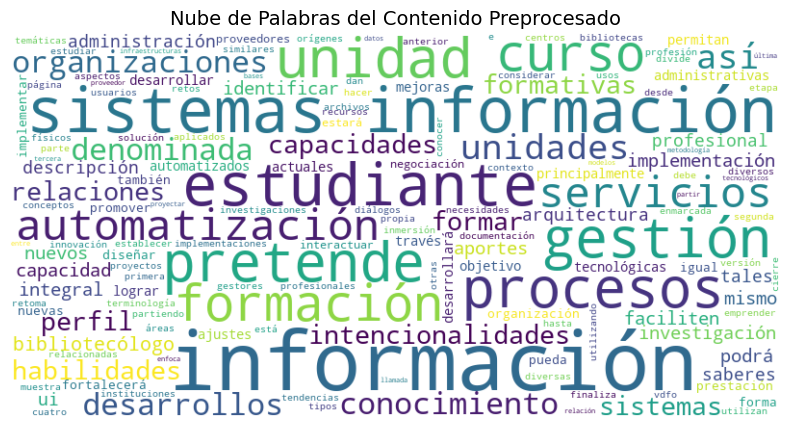

In [8]:
from wordcloud import WordCloud

# Crear una nube de palabras a partir del contenido preprocesado
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(contenido_procesado)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras del Contenido Preprocesado', fontsize=14)
plt.show()


# Parte 2: Recomendación basada en Similitud

In [31]:
# Cargar el archivo Excel con los documentos disponibles para recomendar
file_path = r'D:\Scraping\BD_final_con_vector_actualizado_concatenado.xlsx'
df = pd.read_excel(file_path)

# Revisar y eliminar posibles valores nulos en la columna 'Vector'
df = df.dropna(subset=['Vector'])

# Crear el TF-IDF vectorizer y entrenarlo con los textos de la columna 'Vector'
vectorizador = TfidfVectorizer()
tfidf_matriz = vectorizador.fit_transform(df['Vector'])  # Vectorizar las palabras clave de la columna 'Vector'

# Convertir el texto de entrada (contenido_procesado) al vector TF-IDF usando el mismo vectorizador
texto_vectorizado = vectorizador.transform([contenido_procesado])

# Calcular la similitud de coseno entre el vector del texto de entrada y los vectores en la BD
similaridades = cosine_similarity(texto_vectorizado, tfidf_matriz)[0]

# Ordenar por similitud y obtener las recomendaciones
indices_ordenados = np.argsort(similaridades)[::-1]

# Mostrar las 3 recomendaciones más similares
top_3_indices = indices_ordenados[:3]

# Inicializar listas para los documentos recomendados, sus similitudes y ángulos
titulos_recomendados = []
similitudes_recomendadas = []
angulos_recomendados = []

print("\nLos 3 mejores documentos recomendados son:\n")
for idx in top_3_indices:
    titulo = df.iloc[idx]['Título']
    similitud = similaridades[idx]
    
    # Calcular el ángulo en grados
    angulo = np.degrees(np.arccos(similitud))

    # Añadir a las listas para la gráfica
    titulos_recomendados.append(f"Documento {idx + 1}")
    similitudes_recomendadas.append(similitud)
    angulos_recomendados.append(angulo)

    # Mostrar el resultado en consola
    print(f"- Documento {idx + 1}: {titulo} (Similitud: {similitud:.4f}, Ángulo: {angulo:.2f}°)")



Los 3 mejores documentos recomendados son:

- Documento 200: Microcurriculo (Similitud: 0.9939, Ángulo: 6.35°)
- Documento 201: Texto espía (Similitud: 0.7034, Ángulo: 45.30°)
- Documento 98: Proyecto de gestión de la información en la Escuela de Bibliotecología y Ciencias de la Información de la Universidad de Costa Rica como apoyo a los procesos de mejoramiento continuo (Similitud: 0.2296, Ángulo: 76.72°)


In [34]:
# Definir un umbral de similitud (por ejemplo, 0.5)
umbral = 0.5

# Crear etiquetas de Ground Truth simuladas (1 si similitud > umbral, 0 en caso contrario)
ground_truth_simulado = [1 if similaridad > umbral else 0 for similaridad in similaridades]

# Crear etiquetas de predicciones para las 3 mejores recomendaciones
predicciones = [1 if idx in top_3_indices else 0 for idx in range(len(df))]

# Calcular Precision, Recall y F1-Score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(ground_truth_simulado, predicciones)
recall = recall_score(ground_truth_simulado, predicciones)
f1 = f1_score(ground_truth_simulado, predicciones)

# Mostrar métricas
print("\nEvaluación del sistema de recomendaciones (Simulación):")
print(f"- Precision: {precision:.2f}")
print(f"- Recall: {recall:.2f}")
print(f"- F1-Score: {f1:.2f}")




Evaluación del sistema de recomendaciones (Simulación):
- Precision: 0.67
- Recall: 1.00
- F1-Score: 0.80


# Parte 3: Graficar los Ángulos de Cada Recomendación

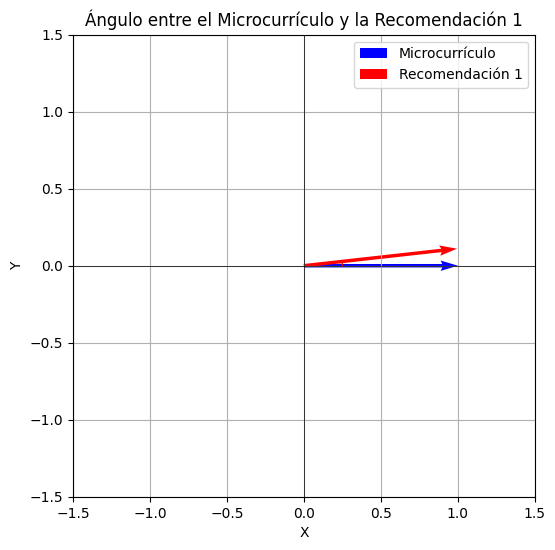

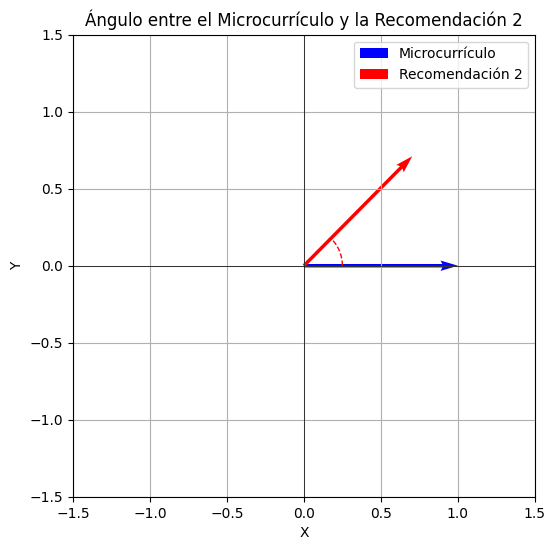

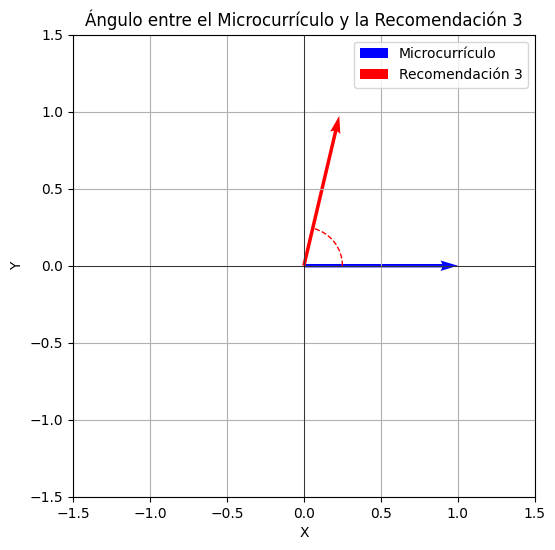

In [33]:

for i in range(3):
    plt.figure(figsize=(6, 6))

    # Vector del microcurrículo (en la dirección positiva del eje X)
    microcurriculo_vector = np.array([1, 0])  # Vector en el eje X

    # Generar el ángulo en radianes para la recomendación correspondiente
    angulo_rad = np.arccos(similitudes_recomendadas[i])
    recomendacion_vector = np.array([np.cos(angulo_rad), np.sin(angulo_rad)])  # Convertir ángulo a coordenadas (para representar en el plano)
    
    # Graficar el vector del microcurrículo
    plt.quiver(0, 0, microcurriculo_vector[0], microcurriculo_vector[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Microcurrículo', linewidth=2)
    
    # Graficar el vector de la recomendación
    plt.quiver(0, 0, recomendacion_vector[0], recomendacion_vector[1], angles='xy', scale_units='xy', scale=1, color='red', label=f'Recomendación {i + 1}', linewidth=2)
    
    # Añadir un arco que represente el ángulo
    arc_radius = 0.5  # Radio del arco
    arc = Arc((0, 0), arc_radius, arc_radius, theta1=0, theta2=np.degrees(angulo_rad), color='red', linestyle='dashed')
    plt.gca().add_patch(arc)

    # Configurar el gráfico
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ángulo entre el Microcurrículo y la Recomendación {i + 1}')
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()
